In [1]:
"""
실행환경은 konlpy==0.5.2 버전이나 지정안하고 install 하여도 됩니다.
"""
# !apt-get update !apt-get install g++ openjdk-8-jdk python-dev python3-dev
# !pip3 install JPype1-py3 
# !pip3 install konlpy 
# !JAVA_HOME="C:\Program Files\Java\jdk1.8.0_271"

'\n실행환경은 konlpy==0.5.2 버전이나 지정안하고 install 하여도 됩니다.\n'

In [2]:
# !pip3 install pandas==1.2.1
# !pip3 install glob2==0.7
# !pip3 install numpy==1.21.5
# !pip3 install seaborn==0.10.0
# !pip3 install matplotlib==3.5.1
# !pip3 install scikit-learn==0.23.2
# !pip3 install wordcloud==1.6.0
# !pip3 install Pillow==8.1.2

# Contents

* 1. READ TRAIN DATASETS
    
* 2. EDA
   * 2.1 Describe
   * 2.2 Outlier
   * 2.3 Visualization
   
   
* 3. REMOVE OUTLIER DATA
 
* 4. FEATURE ENGINEERING
    
* 5. READ TEST DATASETS

* 6. MODEL TRAIN / INFERENCE

* 7. SUBMISSION

&nbsp;

# 1. READ TRAIN DATASETS

- 2017년 설문, 2018년 설문, 2019년 설문, 2020년 설문 CSV를 불러옵니다.

In [3]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumGothic')
print(plt.rcParams['font.family'])

from collections import Counter
from PIL import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

pd.set_option('display.max_columns', None)

warnings.filterwarnings(action='ignore') 

train_path = './data/train/*.csv'
test_path = './data/test/*.csv'
submission_path = './data/sample_submission.csv'
save_path = './data/rf_1536_submission.csv'

know_train = [pd.read_csv(path) for path in sorted(glob(train_path))]

col_2017 = know_train[0].columns
col_2018 = know_train[1].columns
col_2019 = know_train[2].columns
col_2020 = know_train[3].columns

train_col = [col_2017, col_2018, col_2019, col_2020]
years = ['2017', '2018', '2019', '2020']

# 여러개의 텍스트 데이터 하나의 컬럼으로 합침
know_train[0]['total'] = know_train[0][['bq5_2', 'bq19_1', 'bq31', 'bq4_1a', 'bq4_1b', 'bq4_1c', 'bq30', 'bq32', 'bq33', 'bq34', 'bq38_1']].fillna('없음').sum(axis=1)
know_train[1]['total'] = know_train[1][['bq5_2', 'bq28_1', 'bq30', 'bq4_1a', 'bq4_1b', 'bq4_1c', 'bq29', 'bq31', 'bq32', 'bq33', 'bq37_1']].fillna('없음').sum(axis=1)
know_train[2]['total'] = know_train[2][['bq5_2', 'bq20_1', 'bq18_10', 'bq4_1a', 'bq4_1b', 'bq4_1c', 'bq22', 'bq23', 'bq24', 'bq27_1']].fillna('없음').sum(axis=1)
know_train[3]['total'] = know_train[3][['bq5_2', 'bq20_1', 'bq18_10', 'bq4_1a', 'bq4_1b', 'bq4_1c']].fillna('없음').sum(axis=1)

['NanumGothic']


&nbsp;

# 2. EDA



## 2.1 Describe
* 전체 dataset의 Data type, Null값을 확인합니다.

In [4]:
# 2017년도
know_train[0].describe()

,idx,aq1_1,aq2_1,aq3_1,aq4_1,aq5_1,aq6_1,aq7_1,aq8_1,aq9_1,aq10_1,aq11_1,aq12_1,aq13_1,aq14_1,aq15_1,aq16_1,aq17_1,aq18_1,aq19_1,aq20_1,aq21_1,aq22_1,aq23_1,aq24_1,aq25_1,aq26_1,aq27_1,aq28_1,aq29_1,aq30_1,aq31_1,aq32_1,aq33_1,aq34_1,aq35_1,aq36_1,aq37_1,aq38_1,aq39_1,aq40_1,aq41_1,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8_1,bq8_2,bq8_3,bq9,bq10,bq11,bq12_1,bq12_5,bq13,bq14,bq15_1,bq15_2,bq15_3,bq16,bq17,bq18_1,bq18_2,bq18_3,bq18_4,bq18_5,bq18_6,bq18_7,bq19,bq20,bq21,bq22,bq23,bq24_1,bq24_2,bq24_3,bq24_4,bq24_5,bq24_6,bq24_7,bq24_8,bq25,bq26,bq27,bq28,bq29,bq35,bq36,bq37,bq38,bq39_1,bq39_2,knowcode
count,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.0000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.00000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9486.000000,9.486000e+03
mean,4742.500000,3.239827,3.098145,3.107738,2.429475,2.576956,2.791271,2.843032,2.8891,2.976070,3.041746,2.558086,3.028568,2.861902,2.817731,3.027409,2.690070,2.289795,2.181531,2.842083,2.015075,2.04923,2.084124,1.941071,2.847459,2.713367,2.917036,2.739722,3.086549,2.665507,2.541113,2.703247,2.554291,2.728547,2.902172,2.517499,2.588130,2.640207,2.542905,2.421252,1.869386,2.130192,11.208623,1.810036,2.784525,1.567784,1.524563,4.682479,3.707674,3.498102,3.093822,2.930213,3.627451,3.629876,3.032891,3.119334,3.452562,3.107000,3.021611,2.627346,3.300864,3.175311,3.217689,2.889627,3.152224,3.119123,2.834704,3.050074,2.849779,2.704301,3.093612,2.860004,2.588235,2.693127,3.157390,21.927583,1.734135,1.613641,1.582437,1.747101,1.801708,1.838921,1.832385,1.845246,3.535104,3.655387,3.441704,3.328168,2.524141,2.870441,1.314147,41.485874,3.527514,1.137149,1.892157,7.706122e+05
std,2738.516661,1.066843,1.077475,1.063899,1.247805,1.151714,1.150587,1.134836,1.1843,1.171691,1.083614,1.287198,1.120719,1.120805,1.129462,1.022719,1.175699,1.177739,1.258200,1.259375,1.196676,1.17252,1.237307,1.155129,1.153586,1.158391,1.087607,1.133864,0.996459,1.170884,1.198816,1.130011,1.249208,1.097465,1.066538,1.242483,1.163304,1.142694,1.130310,1.126415,1.091645,1.141456,5.780725,1.315480,1.510098,0.495410,0.499423,1.883189,1.574319,0.874006,1.012963,1.002569,0.831852,0.792658,0.889803,0.854207,0.680332,0.863871,0.844004,0.891456,0.879050,0.851025,0.854611,0.730785,0.813577,0.877253,1.058082,0.928391,0.898950,0.832115,0.794875,0.929462,0.731089,0.806778,1.724701,18.239949,0.441816,0.486940,0.493183,0.434696,0.398734,0.367624,0.373544,0.361689,0.692136,0.700513,0.732790,0.770668,0.789492,0.852283,0.464200,10.405128,1.140722,0.344023,1.635230,1.911786e+06
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

In [5]:
# 2018년도
know_train[1].describe()

,idx,cq1,cq2,cq3,cq4,cq5,cq6,cq7,cq8,cq9,cq10,cq11,cq12,cq13,cq14,cq15,cq16,cq17,cq18,cq19,cq20,cq21,cq22,cq23,cq24,cq25,cq26,cq27,cq28,cq29,cq30,cq31,cq32,cq33,cq34,cq35,cq36,cq37,cq38,cq39,cq40,cq41,cq42,cq43,cq44,cq45,cq46,cq47,cq48,cq49,cq50_1,cq50_2,cq50_3,cq50_4,cq50_5,cq50_6,cq50_7,cq50_8,iq1,iq2,iq3,iq4,iq5,iq6,bq1,bq2,bq3,bq6,bq7,bq8_1,bq8_2,bq8_3,bq9,bq10,bq11,bq12_5,bq13,bq14,bq15,bq16,bq17,bq18,bq19,bq20,bq232,bq233,bq27,knowcode
count,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000
mean,14027.132165,4.405974,2.460317,4.057981,3.335869,3.144951,4.118166,3.602734,3.455026,3.350639,2.706790,3.039352,2.792659,2.554453,4.459546,2.699515,2.024030,3.191138,2.452271,2.056107,1.535053,1.889330,1.676477,1.509259,1.459325,1.260692,1.562941,1.698082,1.873016,3.376433,2.451499,1.667328,2.599427,2.045304,3.431658,2.293871,3.242725,3.330798,3.016534,2.776014,2.250000,3.523038,3.210758,3.001653,2.365851,2.132937,3.158510,1.138889,1.129189,2.777006,1.237875,1.298721,1.248898,1.143078,1.045635,1.040564,1.054453,1.055115,3.300044,2.991843,2.506063,3.156085,3.004630,3.024030,10.941138,2.069114,2.833664,4.542328,3.624890,3.559854,3.071429,2.856812,3.620922,3.673721,3.102623,3.463073,1.640432,1.211420,1.591270,1.546958,1.468364,1.307540,1.581349,3.502205,0.047399,0.098325,1.828042,387185.500772
std,2621.954530,0.832704,1.282916,1.181729,1.513530,1.430967,1.014683,1.066949,1.191306,1.106779,1.313837,1.197089,1.043164,1.052534,1.054734,1.463437,1.432906,0.970549,1.485436,1.330777,1.002084,1.334931,1.154261,1.073386,1.031367,0.733655,1.093373,1.210419,1.250541,1.383696,1.178139,0.723329,1.407349,1.145389,1.243199,1.621449,1.068873,1.019287,1.180330,1.181979,1.053575,1.029559,1.089483,1.125318,1.088355,1.179590,1.382444,0.406241,0.352103,1.291146,0.576108,0.598980,0.538250,0.437505,0.254841,0.232673,0.267503,0.284158,1.054322,1.165190,1.278869,1.155193,1.113046,1.081548,5.627042,1.414590,1.547257,1.879683,1.569557,0.863364,1.075976,1.058898,0.904267,0.880728,0.971281,0.760016,0.835697,0.409416,1.103228,0.498481,0.801616,0.688501,0.709633,5.182460,0.310337,0.534582,0.386029,292700.373247
min,9486.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,11101.000000
25%,11757.750000,4.000000,1.000000,4.000000,2.000000,2.000000,4.000000,3.00000

In [6]:
# 2019년도
know_train[2].describe()

,idx,sq1,sq2,sq3,sq4,sq5,sq6,sq7,sq8,sq9,sq10,sq11,sq12,sq13,sq14,sq15,sq16,kq1_1,kq1_2,kq2_1,kq2_2,kq3_1,kq3_2,kq4_1,kq4_2,kq5_1,kq5_2,kq6_1,kq6_2,kq7_1,kq7_2,kq8_1,kq8_2,kq9_1,kq9_2,kq10_1,kq10_2,kq11_1,kq11_2,kq12_1,kq12_2,kq13_1,kq13_2,kq14_1,kq14_2,kq15_1,kq15_2,kq16_1,kq16_2,kq17_1,kq17_2,kq18_1,kq18_2,kq19_1,kq19_2,kq20_1,kq20_2,kq21_1,kq21_2,kq22_1,kq22_2,kq23_1,kq23_2,kq24_1,kq24_2,kq25_1,kq25_2,kq26_1,kq26_2,kq27_1,kq27_2,kq28_1,kq28_2,kq29_1,kq29_2,kq30_1,kq30_2,kq31_1,kq31_2,kq32_1,kq32_2,kq33_1,kq33_2,bq1,bq2,bq3,bq4,bq5,bq8_1,bq8_2,bq12_1,bq12_2,bq12_3,bq13_1,bq13_3,bq14_1,bq14_2,bq14_3,bq14_5,bq15,bq16_1,bq16_2,bq16_3,bq16_4,bq16_5,bq17,bq18_1,bq18_2,bq18_3,bq18_4,bq18_5,bq18_6,bq18_7,bq18_8,bq18_9,bq19,bq21_1,bq21_2,bq26,bq28,knowcode
count,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.00000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.00000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8555.000000,8554.000000,8554.000000,8554.000000,8554.000000,8554.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8555.000000
mean,22847.530684,3.756984,3.767972,3.918527,3.247691,3.738515,3.617650,3.577674,3.700994,3.771128,3.595558,3.88720,4.065342,3.712800,3.284863,2.989714,3.347049,2.093279,2.002922,2.377674,2.560608,1.904851,1.731268,2.139568,2.086265,2.840678,3.068966,1.864757,1.606780,1.807364,1.365985,1.296552,0.517241,2.232379,2.369608,1.886733,1.685096,1.752425,1.386674,1.399883,0.727411,2.175687,2.015313,2.079018,2.204909,1.687551,1.324722,1.591584,1.136295,1.477732,0.855172,2.248627,2.263939,1.783168,1.438925,1.572764,1.106721,1.573700,0.949036,2.152659,2.122618,2.377674,2.575921,2.128697,2.151373,2.190298,2.31806,1.614144,1.078434,1.457393,0.925424,1.426534,0.842081,2.456108,2.456224,2.152776,2.141438,2.150321,2.395558,2.496902,2.773933,1.625950,1.079953,11.338749,1.837054,2.830976,1.518293,1.466277,3.534074,3.095617,3.115020,4.092928,4.782817,2.597732,3.198854,3.602408,4.838555,4.072598,3.148620,2.739125,2.738190,2.590388,2.583606,2.158442,2.150257,3.070159,1.852198,1.764733,1.736202,1.824135,1.819224,1.769995,1.872778,1.874532,1.887979,1.810571,2.443171,2.705683,41.727198,1.147919,394103.558153
std,2470.738765,0.940339,0.912364,0.891482,1.154235,0.969011,0.984349,0.978679,0.940797,0.911046,0.946712,0.91631,0.867035,1.004045,1.042738,1.155195,1.149896,1.154813,1.924970,1.126899,1.905020,1.079413,1.904709,1.258098,2.151616,1.312867,2.035324,1.119916,1.960243,1.151010,1.855585,0.772802,1.306635,1.179378,2.054475,1.181419,2.112558,1.136346,1.949049,0.880981,1.541125,1.234061,1.974617,1.126372,2.091260,1.035145,1.867418,1.006583,1.799159,0.949540,1.609954,1.254320,2.071552,1.068759,1.847875,0.972107,1.758295,1.062589,1.663109,1.269074,2.158669,1.253228,2.126726,1.168287,1.987422,1.159694,2.05778,1.101113,1.817496,0.891680,1.680126,0.843533,1.561896,1.299731,1.979151,

In [7]:
# 2020년도
know_train[3].describe()

,idx,saq1_1,saq2_1,saq3_1,saq4_1,saq5_1,saq6_1,saq7_1,saq8_1,saq9_1,saq10_1,saq11_1,saq12_1,saq13_1,saq14_1,saq15_1,saq16_1,saq17_1,saq18_1,saq19_1,saq20_1,saq21_1,saq22_1,saq23_1,saq24_1,saq25_1,saq26_1,saq27_1,saq28_1,saq29_1,saq30_1,saq31_1,saq32_1,saq33_1,saq34_1,saq35_1,saq36_1,saq37_1,saq38_1,saq39_1,saq40_1,saq41_1,saq42_1,saq43_1,saq44_1,vq1,vq2,vq3,vq4,vq5,vq6,vq7,vq8,vq9,vq10,vq11,vq12,vq13,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8_1,bq8_2,bq8_3,bq9,bq10,bq11,bq12_1,bq12_2,bq12_3,bq12_4,bq12_5,bq13_1,bq13_2,bq13_3,bq14_1,bq14_2,bq14_3,bq14_4,bq14_5,bq14_6,bq14_7,bq15,bq16_1,bq16_2,bq16_3,bq16_4,bq16_5,bq16_6,bq16_7,bq16_8,bq16_9,bq16_10,bq17,bq18_1,bq18_2,bq18_3,bq18_4,bq18_5,bq18_6,bq18_7,bq18_8,bq18_9,bq19,bq20,bq21_1,bq21_2,bq21_3,bq21_4,bq22_1,bq22_2,bq22_3,bq22_4,bq22_5,bq22_6,bq23_1,bq23_2,bq23_3,bq24,bq25,bq26,bq27_1,bq27_2,bq29,knowcode
count,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.00000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000
mean,31187.500000,3.152302,3.300788,2.661044,3.061192,2.682221,2.933145,2.649840,2.984487,3.137158,2.760158,2.662891,2.840803,3.235410,2.831692,2.877370,2.902487,2.618936,2.496429,2.742305,2.988180,3.172125,3.030288,2.993967,2.369737,2.472421,2.424895,2.625708,2.341295,2.633957,2.365797,2.541000,2.434130,2.614750,2.571042,2.484856,2.509973,2.386727,2.652549,2.609210,2.559468,2.582861,2.428343,3.061069,2.670525,3.634327,3.440163,3.208816,3.190840,3.455430,2.966264,3.344127,3.270623,2.977592,3.282073,3.381310,3.223713,3.360133,11.207461,1.678404,2.680867,1.473652,1.716080,4.326890,3.723713,3.510096,3.235164,3.093573,3.753263,3.681729,3.251293,3.355208,4.154026,4.215957,4.132480,3.560576,2.668185,3.428097,3.319503,3.518715,3.384388,3.209801,3.344250,3.046787,3.395962,3.477099,3.335262,3.886604,3.446196,3.545802,3.423541,3.438808,3.657597,3.966264,3.468850,3.191578,3.92391,3.693425,1.952967,1.913568,1.911967,1.942502,1.947304,1.935361,1.948904,1.949766,1.957646,1.760034,2.773947,2.446688,2.406550,2.584831,1.647624,5.810638,5.524994,5.318271,4.689855,4.634327,4.943487,5.256710,4.950012,4.981532,1.298695,41.264836,3.504679,1.124969,1.808422,42.962078,394210.606008
std,2344.763776,1.146062,1.066221,1.203669,1.137325,1.188378,1.197661,1.300268,1.074726,1.033797,1.169576,1.189216,1.149418,1.030617,1.180795,1.194117,1.118668,1.225956,1.227501,1.193177,1.161233,1.071474,1.139919,1.095080,1.217342,1.173651,1.238601,1.248575,1.304795,1.252642,1.274252,1.237216,1.238132,1.226154,1.254938,1.321613,1.314094,1.208999,1.277595,1.207539,1.184068,1.202486,1.122077,1.009724,1.069343,0

In [8]:
for idx, trainset in enumerate(know_train):
    print('==========================')
    print(years[idx])
    print(trainset.info())
    print()
    print(trainset.isnull().sum())
    print('==========================')

2017
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9486 entries, 0 to 9485
Columns: 157 entries, idx to total
dtypes: float64(1), int64(95), object(61)
memory usage: 11.4+ MB
None

idx         0
aq1_1       0
aq1_2       0
aq2_1       0
aq2_2       0
           ..
bq41_1      0
bq41_2      0
bq41_3      0
knowcode    0
total       0
Length: 157, dtype: int64
2018
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9072 entries, 0 to 9071
Columns: 142 entries, idx to total
dtypes: float64(69), int64(19), object(54)
memory usage: 9.8+ MB
None

idx          0
cq1          0
cq2          0
cq3          0
cq4          0
            ..
bq41_1       1
bq41_2       1
bq41_3      34
knowcode     0
total        0
Length: 142, dtype: int64
2019
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8555 entries, 0 to 8554
Columns: 154 entries, idx to total
dtypes: float64(27), int64(94), object(33)
memory usage: 10.1+ MB
None

idx         0
sq1         0
sq2         0
sq3         0
sq4         0
   

&nbsp;

## 2.2 Outlier

* value_counts()를 이용해 연도별 모든 컬럼에 이상치를 확인합니다.
* 아래에 해당되는 범주형 column들은 일정범위에서 벗어나는것으로 보이는 이상치가 존재합니다.

* 2018 - bq20, bq35, bq38_2, bq39, bq40
* 2019 - bq8_1, bq12_2, bq12_3, bq12_4, bq14_1, bq14_2, bq14_3, bq25, bq29

In [9]:
outlier = {
    '2018' : ['bq20', 'bq35', 'bq38_2', 'bq39', 'bq40'],
    '2019' : ['bq8_1', 'bq12_2', 'bq12_3', 'bq12_4', 
        'bq14_1', 'bq14_2', 'bq14_3', 'bq25', 'bq29']}

for idx, year in enumerate(['2018', '2019']):
    out_col = outlier[year]
    for col in out_col:
        print(f"-- {col} --")
        print(know_train[idx+1][col].value_counts())
        print()
    

-- bq20 --
4.0      3047
3.0      2633
2.0      1708
5.0       958
1.0       694
100.0      13
90.0        6
80.0        5
70.0        3
85.0        3
20.0        1
60.0        1
Name: bq20, dtype: int64

-- bq35 --
1.0                   5336
2.0                   2828
1                      556
2                      318
35.0                     3
39.0                     3
32.0                     2
31.0                     2
37.0                     2
27.0                     2
40.0                     2
26.0                     2
50.0                     2
33                       1
38                       1
42                       1
30                       1
 라이트룸 등의 컴퓨터 프로그램"       1
46.0                     1
56.0                     1
53.0                     1
52.0                     1
47.0                     1
44.0                     1
42.0                     1
25.0                     1
45                       1
Name: bq35, dtype: int64

-- bq38_2 --
      7777
6    

&nbsp;

* 아래에 해당되는 column들은 숫자로 이루어진 범주형 변수에 문자열이 들어가있는 이상치가 존재합니다.

* 2018 - bq37, bq35, bq40, bq4, bq5_1, bq28, bq34
* 2019 - bq27, bq6, bq7, bq8_3, bq9, bq10, bq11, bq12_4, bq20,bq21_3, bq25

In [10]:
text_outlier = {
    '2018' : ['bq37', 'bq35', 'bq40', 'bq4', 'bq5_1', 'bq28', 'bq34'],
    '2019' : ['bq27', 'bq6', 'bq7', 'bq8_3', 'bq9', 'bq10', 'bq11',
        'bq12_4', 'bq20','bq21_3', 'bq25']}

for idx, year in enumerate(['2018', '2019']):
    out_col = text_outlier[year]
    for col in out_col:
        print(f"-- {col} --")
        print(know_train[idx+1][col].value_counts())
        print()

-- bq37 --
4          4120
2          1990
3          1220
5           985
6           423
1           300
전기공학          4
기계공학          3
기계            3
전자전기공학        2
금속            2
전기            2
자동차           1
전자공학          1
기계학           1
이과            1
전자전기 공학       1
기계과           1
전기전자          1
시각디자인         1
디자이너          1
금속가공          1
공고졸업          1
세무회계          1
항해학과          1
정보처리          1
이             1
멀티미디어         1
금속기계          1
전자전기학         1
Name: bq37, dtype: int64

-- bq35 --
1.0                   5336
2.0                   2828
1                      556
2                      318
35.0                     3
39.0                     3
32.0                     2
31.0                     2
37.0                     2
27.0                     2
40.0                     2
26.0                     2
50.0                     2
33                       1
38                       1
42                       1
30                       1
 라이트룸 등의 컴퓨터 

&nbsp;

## 2.3 Visualization

* 연도별로 값이 많은 클래스 5개 설문 주제별 평균으로 비교합니다

In [11]:
survey_title = {
        '2017' : ['업무활동', '직무만족', '직무몰입', '직업스트레스', '기술적 변화요인1', '기술적 변화요인2', '기술적 변화요인3'],
        '2018' : ['업무환경', '업무환경-기술', '흥미', '사회적 평판', '직무만족'],
        '2019' : ['성격', '지식', '사회적 평판', '직무만족', '직무몰입','정신건강/긍정','일과생활균형/부정','직업세계변화/새로운','직업세계변화/기타'],
        '2020' : ['업무수행능력','가치관','사회적평판','직무만족','직무몰입','일의가치','직업의미','직업세계변화/새로운',
                 '직업세계변화/기타','코로나영향','직무중심 직업유사성 지식','직무중심 직업유사성 업무수행능력','직무중심 직업유사성 중요도']}
survey = {
        '2017' : [['aq1_1','aq41_2'],['bq12_1','bq14'],['bq15_1','bq15_3'],['bq18_1','bq18_7'],['bq20','bq23'],
                  ['bq24_1','bq24_8'],['bq25','bq29']],

        '2018' : [['cq1', 'cq49'],['cq50_1','cq50_8'],['iq1','iq6'],['bq8_1','bq8_3'],['bq12_1','bq12_5']],
                  
        '2019' : [['sq1', 'sq16'],['kq1_1','kq33_2'],['bq8_1','bq8_3'],['bq12_1','bq12_5'],['bq13_1','bq13_3'],
                 ['bq14_1','bq14_5'],['bq15','bq17'],['bq18_1','bq18_4'],['bq18_5','bq19']],
                  
        '2020' : [['saq1_1','saq44_2'],['vq1','vq13'],['bq8_1','bq8_3'],['bq12_1','bq12_5'],['bq13_1', 'bq13_3'],
                 ['bq14_1','bq14_7'],['bq16_1','bq16_10'],['bq18_1','bq18_4'],['bq18_5','bq18_9'],
                 ['bq21_1','bq21_4'],['bq22_1','bq22_3'],['bq22_4','bq22_6'],['bq23_1','bq23_3']]}
colors = ['red', 'orange', 'yellow', 'green', 'blue']

def is_digit(str):
    try:
        tmp = float(str)
        return True
    except ValueError:
        return False

def survey_draw(trainset, year):
    knowcode = trainset['knowcode'].value_counts()[:5].index.tolist()
    rows = len(survey[year])
    for idx1, (sur, title_name) in enumerate(zip(survey[year],survey_title[year])):
        plt.figure(figsize=(16,18))
        sur_col = trainset.loc[:, sur[0]:sur[1]].columns
        for sub in sur_col:
            trainset[sub] = trainset[sub].apply(lambda x : x if is_digit(str(x)) else 0)
                                                
        trainset.loc[:, sur[0]:sur[1]] = trainset.loc[:, sur[0]:sur[1]].fillna(-1).replace(' ', -1).astype(float).replace(-1, np.NaN)
        
        for idx, code in enumerate(knowcode):
            key = trainset[trainset.knowcode == code].loc[:, sur[0]:sur[1]].mean(skipna=True).index
            value = trainset[trainset.knowcode == code].loc[:, sur[0]:sur[1]].mean(skipna=True).values
            x = np.arange(len(key))
            plt.subplot(rows, 5, idx+1)
            plt.title(f"{code}_{title_name}")
            plt.bar(x, value, color=colors[idx])
            plt.xticks(x, key, rotation = 45)
        plt.tight_layout()
        plt.show()

* 2017년 Top5

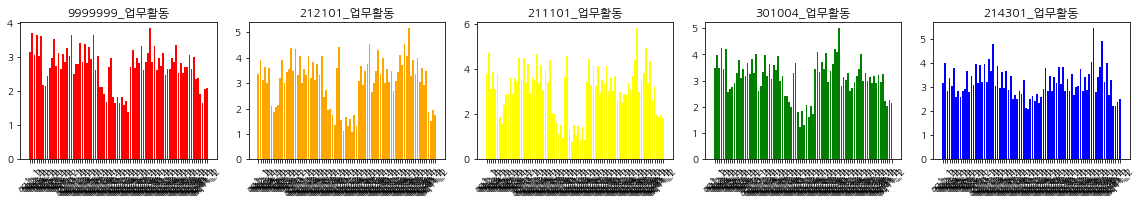

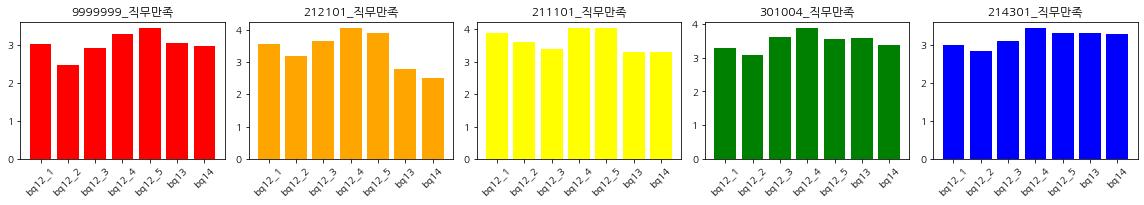

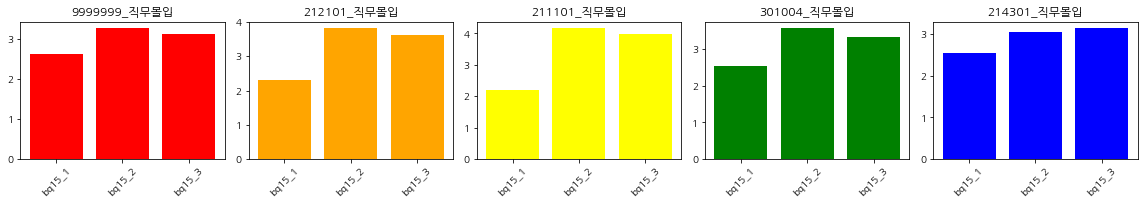

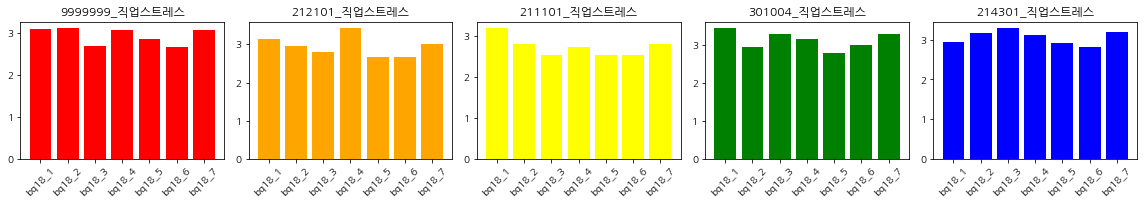

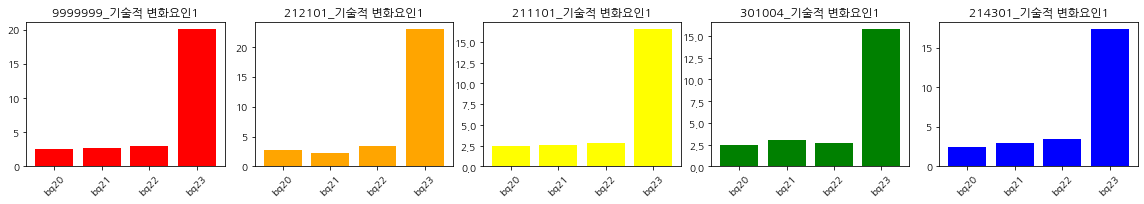

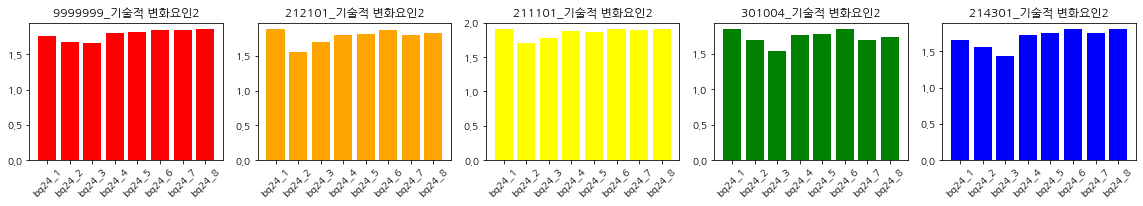

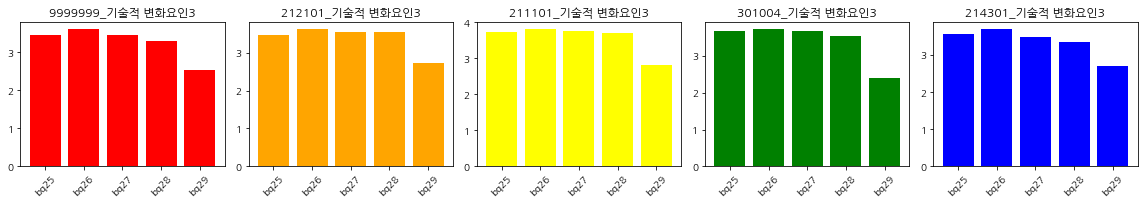

In [12]:
survey_draw(know_train[0].copy(), '2017')

* 2018년 Top5

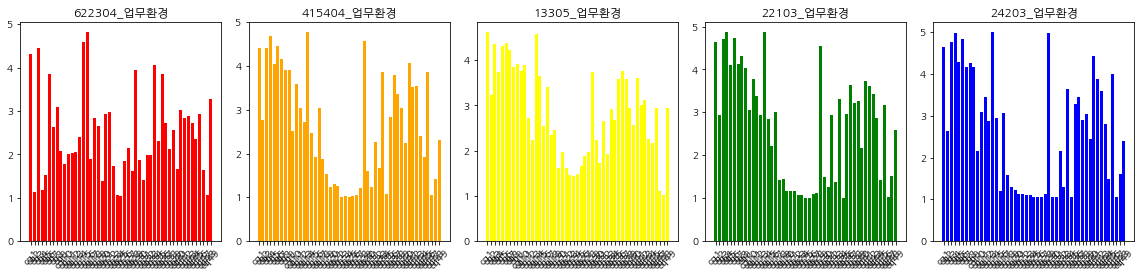

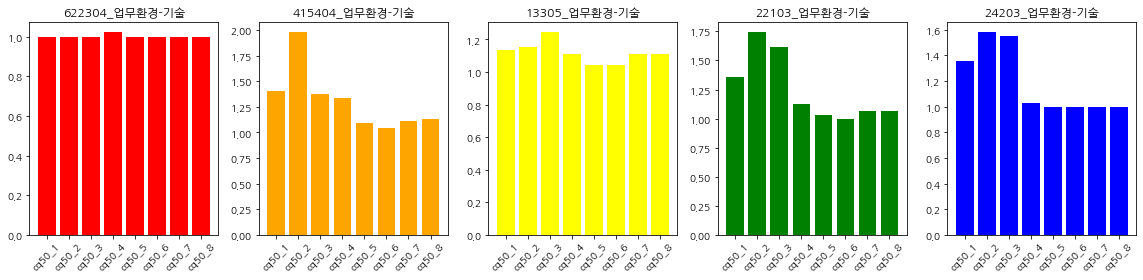

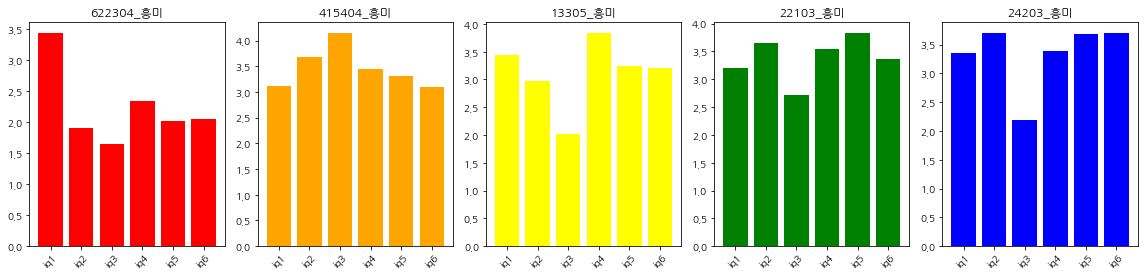

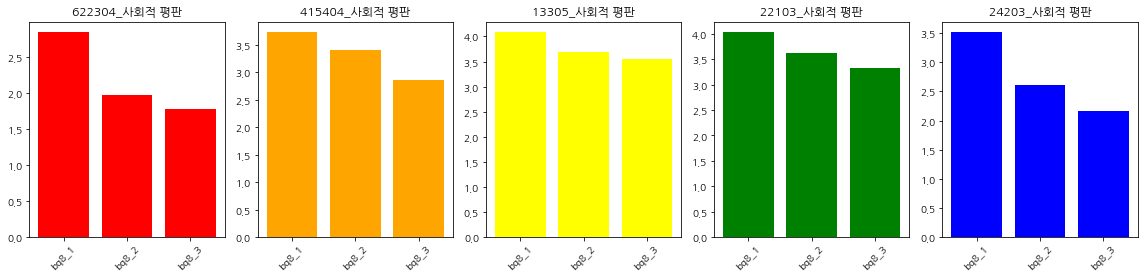

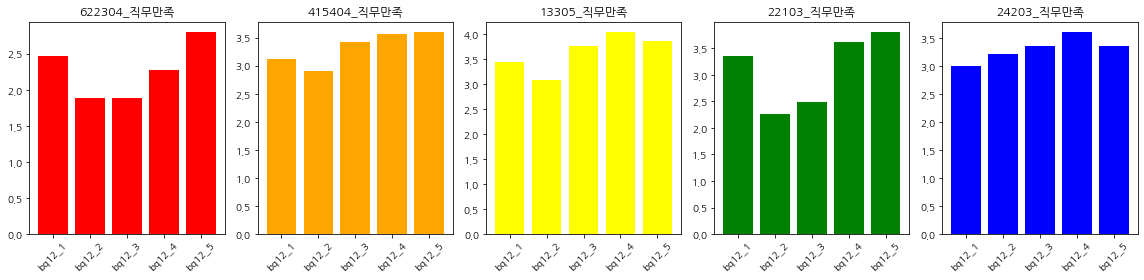

In [13]:
survey_draw(know_train[1].copy(), '2018')

* 2019년 Top5

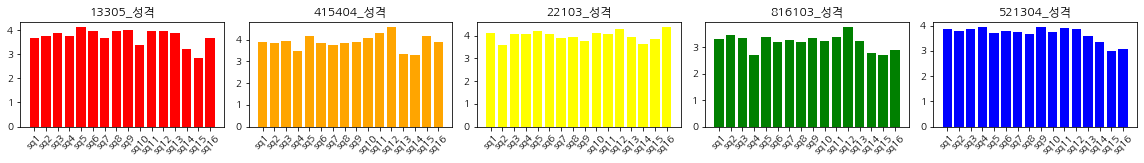

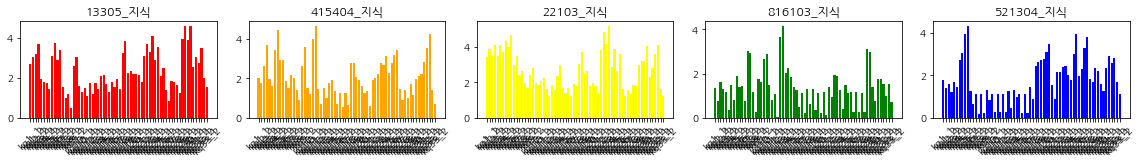

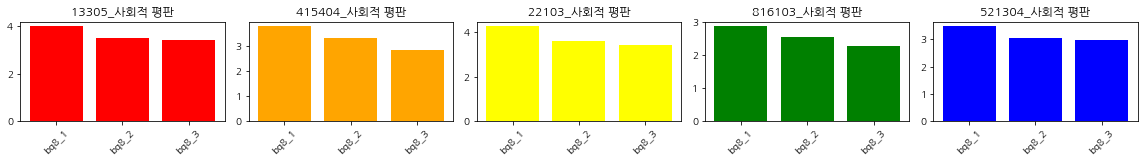

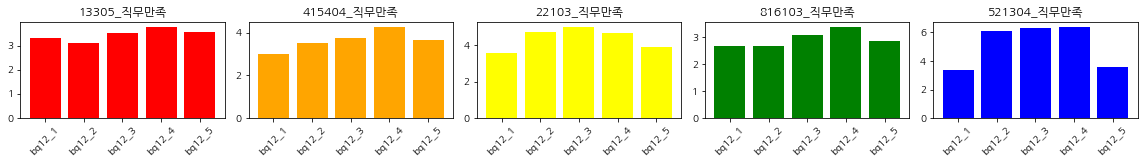

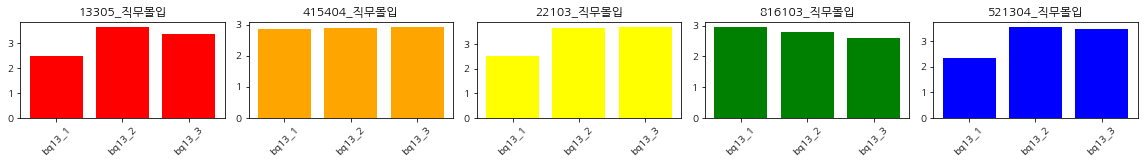

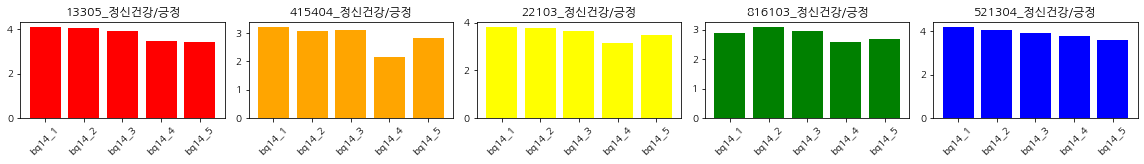

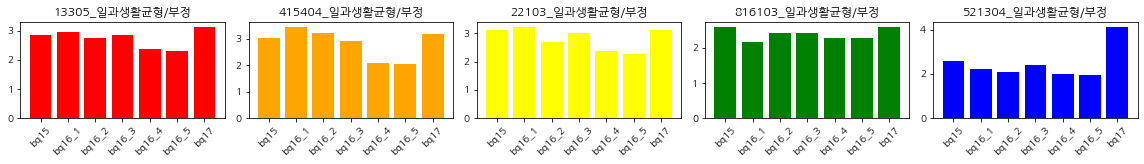

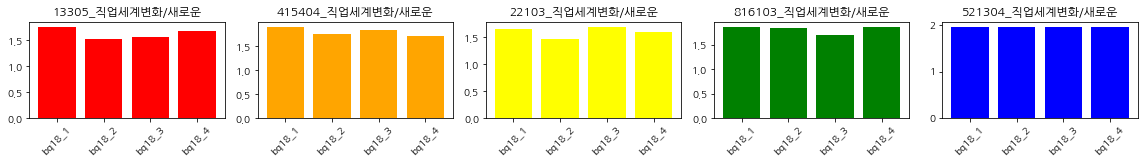

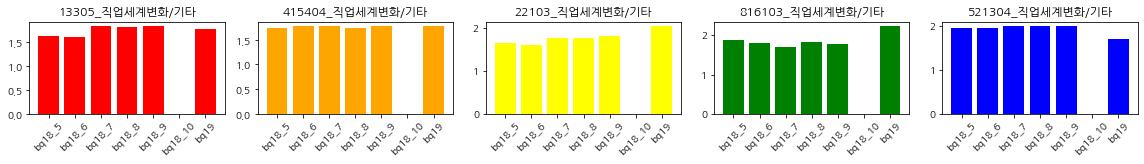

In [14]:
survey_draw(know_train[2].copy(), '2019')

* 2020년 Top5

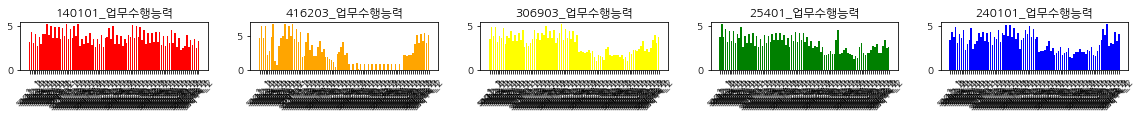

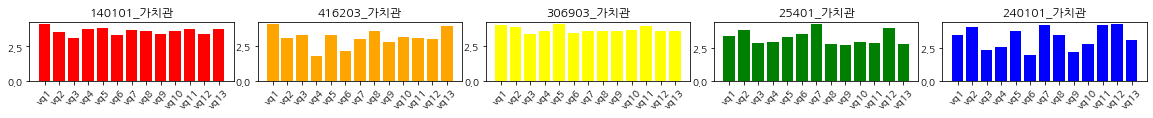

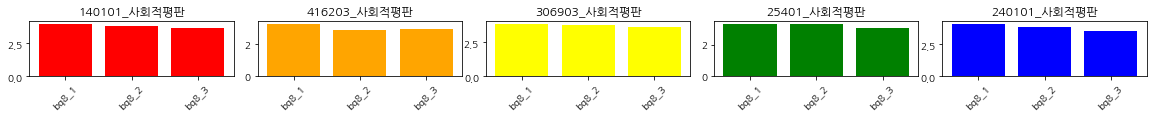

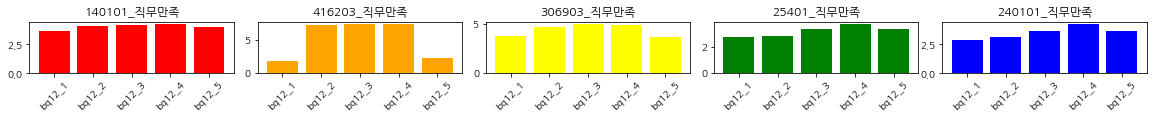

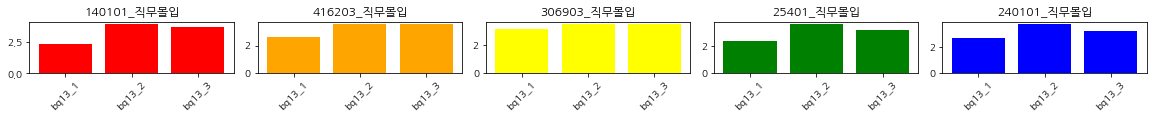

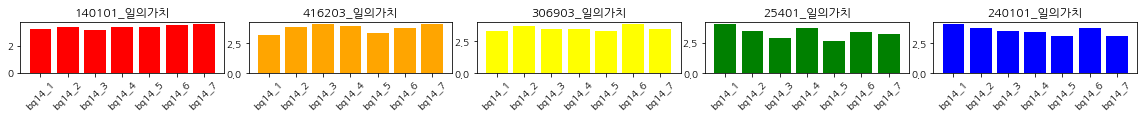

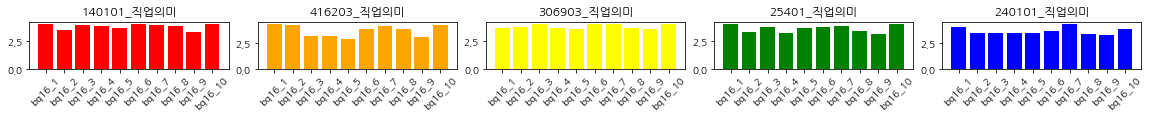

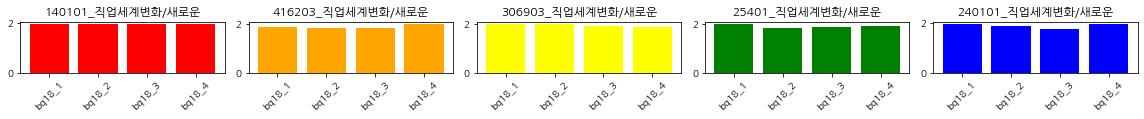

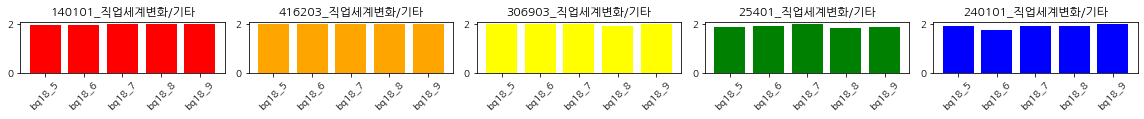

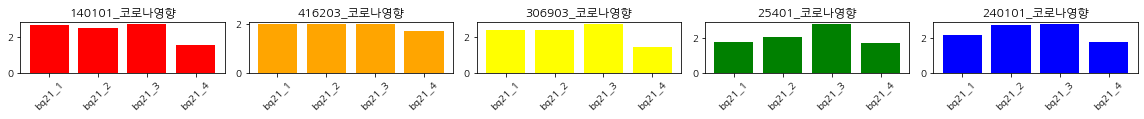

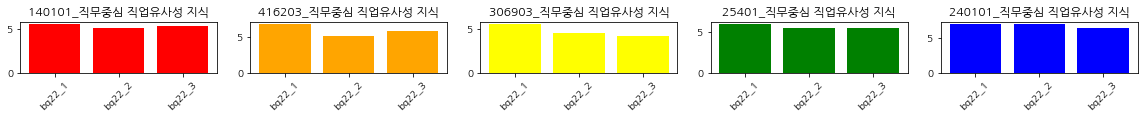

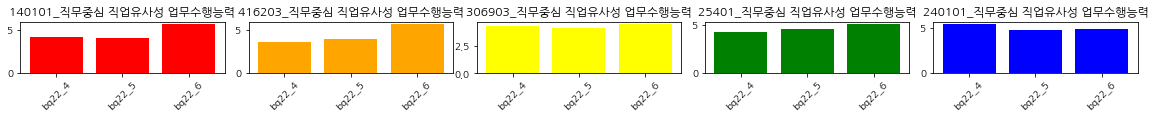

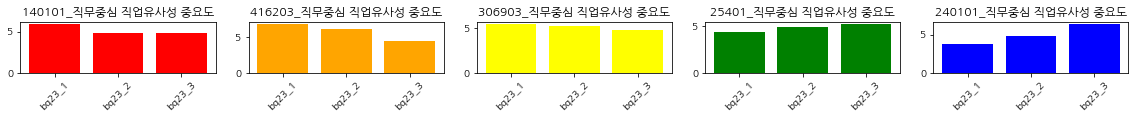

In [15]:
survey_draw(know_train[3].copy(), '2020')

&nbsp;

* 연도별로 값이 많은 클래스 5개 연령별 최소, 최대, 평균값 으로 비교합니다

In [16]:
def age_draw(trainset, year):
    knowcode = trainset['knowcode'].value_counts()[:5].index.tolist()
    keys = ['Min', 'Max', 'Mean']
    
    plt.figure(figsize=(20,4))
    for idx, code in enumerate(knowcode):
        age = age_dic[year]
        
        trainset[age] = trainset[age].replace(' ', np.NaN).apply(lambda x : x if is_digit(str(x)) else 0)
        trainset[age] = trainset[age].fillna(-1).replace(' ', -1).astype(int).replace(-1, np.NaN)
        min_val = trainset[trainset['knowcode'] == code][age].min(skipna=True)
        max_val = trainset[trainset['knowcode'] == code][age].max(skipna=True)
        mean_val = int(trainset[trainset['knowcode'] == code][age].mean(skipna=True))
        x = np.arange(len(keys))
        plt.subplot(1,5,idx+1)
        plt.title(f"{code}_Age")
        plt.bar(x, [min_val, max_val, mean_val], color = colors[idx])
        plt.xticks(x, keys)
    plt.tight_layout()
    plt.show()
    
age_dic = {'2017': 'bq37', '2018': 'bq36', '2019': 'bq26', '2020': 'bq25'}

* 2017년 Top5

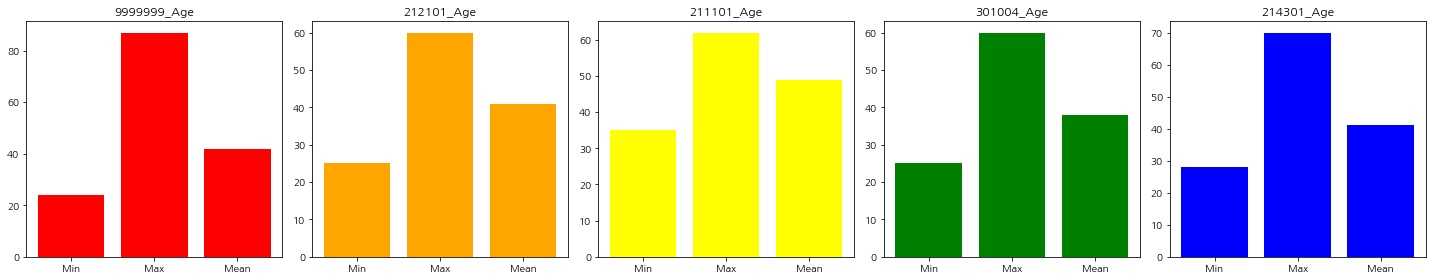

In [17]:
age_draw(know_train[0].copy(), '2017')

* 2018년 Top5

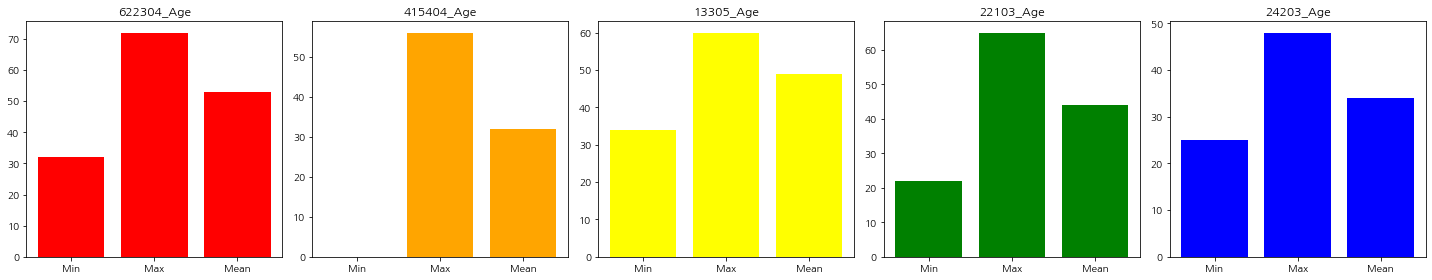

In [18]:
age_draw(know_train[1].copy(), '2018')

* 2019년 Top5

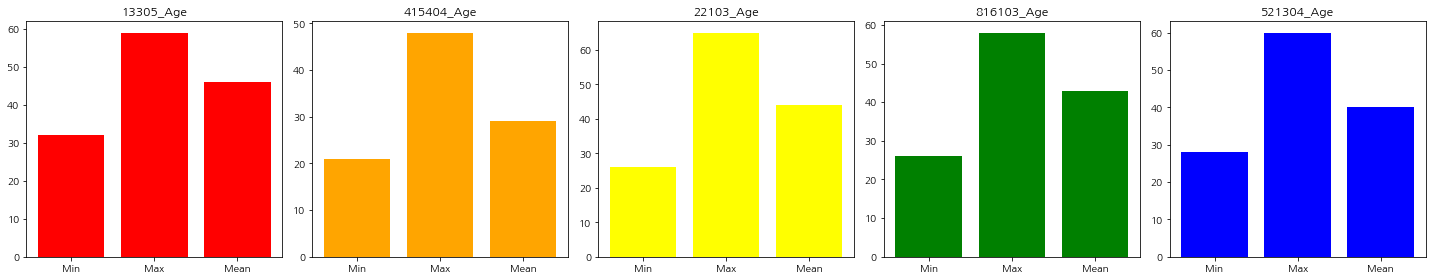

In [19]:
age_draw(know_train[2].copy(), '2019')

* 2020년 Top5

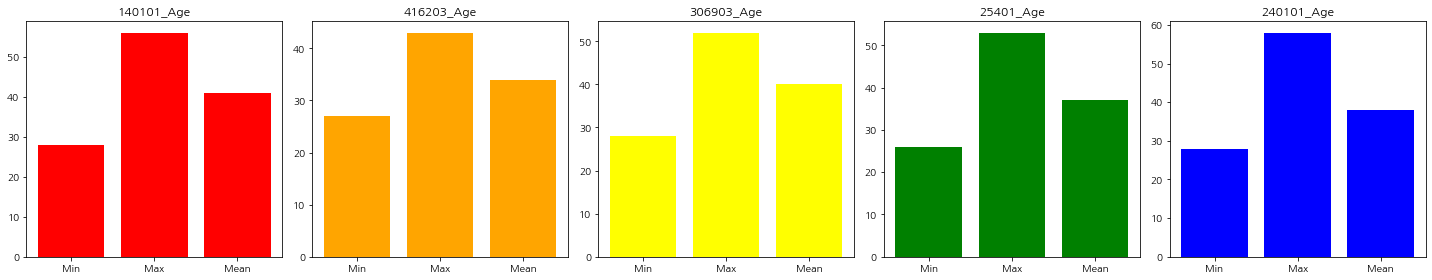

In [20]:
age_draw(know_train[3].copy(), '2020')

&nbsp;

* 연도별로 값이 많은 클래스 5개 '근로소득', '초입임금', '순수입' 의 평균값 으로 비교합니다

In [21]:
def income_draw(trainset, year):
    knowcode = trainset['knowcode'].value_counts()[:5].index.tolist()
    keys = ['근로소득', '초임임금', '순수입']
    income = income_dic[year]
    trainset[income] = trainset[income].fillna(-1).replace(' ', -1).astype(int).replace(-1, np.NaN)
    plt.figure(figsize=(20,4))
    for idx, code in enumerate(knowcode):
        income_1 = trainset[trainset['knowcode'] == code][income[0]].mean(skipna=True)
        income_2 = trainset[trainset['knowcode'] == code][income[1]].mean(skipna=True)
        income_3 = trainset[trainset['knowcode'] == code][income[2]].mean(skipna=True)
        x = np.arange(len(keys))
        plt.subplot(1,5,idx+1)
        plt.title(f"{code}_Income")
        plt.bar(x, [income_1, income_2, income_3], color = colors[idx])
        plt.xticks(x, keys)
    plt.tight_layout()
    plt.show()
    
income_dic = {'2017': ['bq41_1', 'bq41_2', 'bq41_3'], '2018': ['bq41_1','bq41_2','bq41_3'],
               '2019': ['bq31_1', 'bq31_2', 'bq31_3'], '2020': ['bq30_1','bq30_2','bq30_3']}

* 2017년 Top5

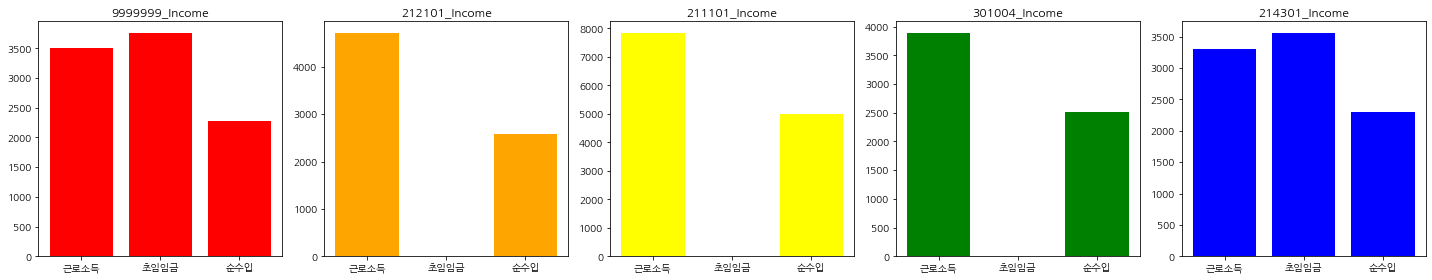

In [22]:
income_draw(know_train[0], '2017')

* 2018년 Top5

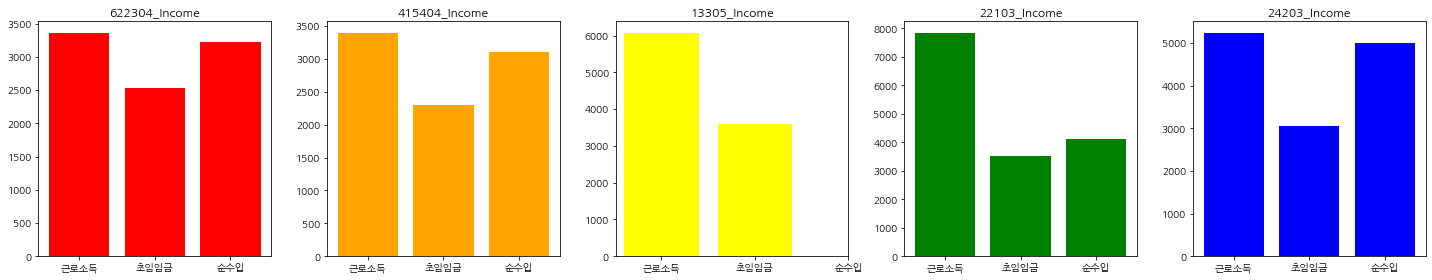

In [23]:
income_draw(know_train[1], '2018')

* 2019년 Top5

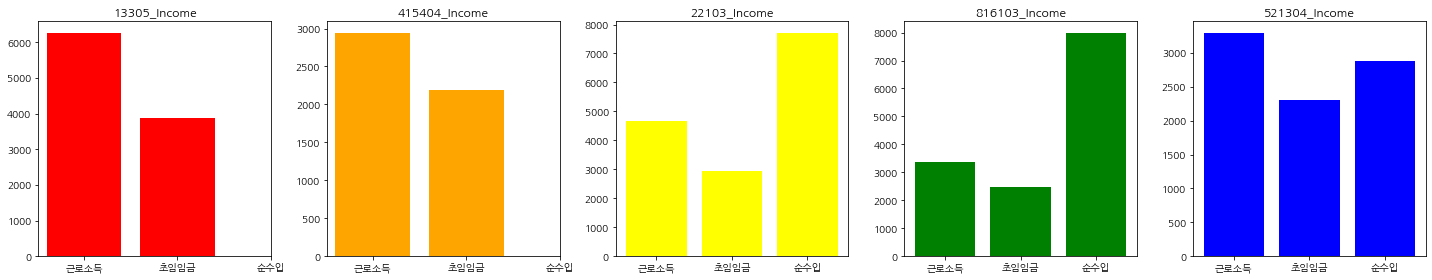

In [24]:
income_draw(know_train[2], '2019')

* 2020년 Top5

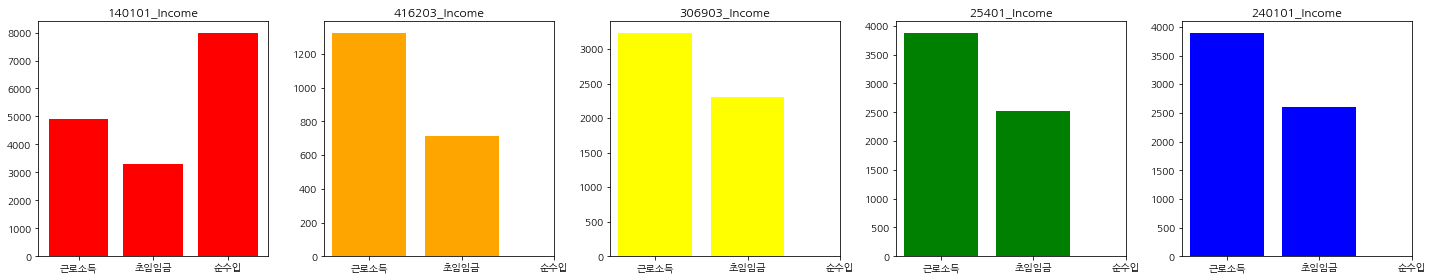

In [25]:
income_draw(know_train[3], '2020')

&nbsp;

* 자연어를 konlpy의 Okt를 이용하여 명사처리 합니다.
* 연도별로 클래스수가 많은 5개를 뽑아 Wordcloud를 이용하여 시각화 합니다.
* 각 클래스별로 보았을때 어느 직종에 포함되는지 유추할 수 있습니다.

In [26]:
def wordcloud(trainset):
    okt = Okt()
    knowcode = trainset['knowcode'].value_counts()[:5].index.tolist()
    for idx, code in enumerate(knowcode):
        know_text = ''.join(trainset[trainset.knowcode == code]['total'].values.tolist())
        nouns = okt.nouns(know_text)
        words = [n for n in nouns if len(n) > 1]

        c = Counter(words)

        wc = WordCloud(font_path='malgun', width=1000, height=1000, scale=2.0, max_font_size=150)
        gen = wc.generate_from_frequencies(c)
        plt.figure()
        plt.title(code)
        plt.imshow(gen)

* 2017년도 Top5

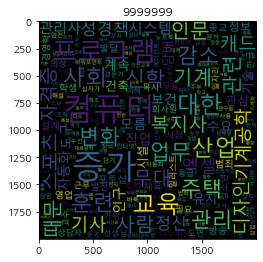

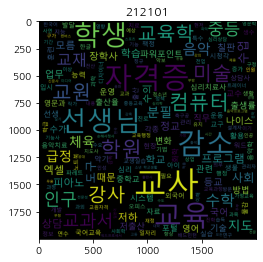

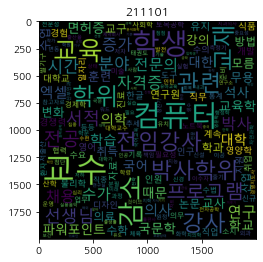

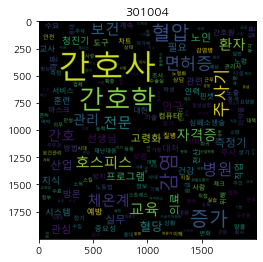

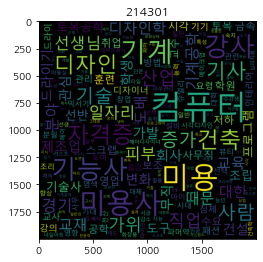

In [27]:
wordcloud(know_train[0].copy())

* 2018년도 Top5

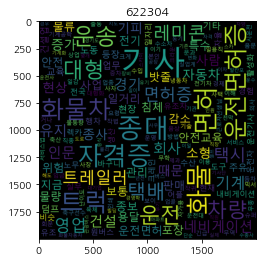

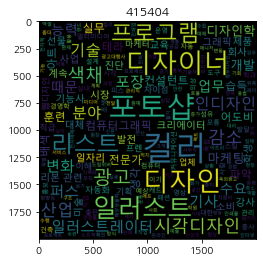

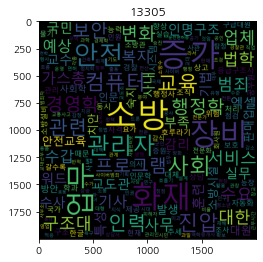

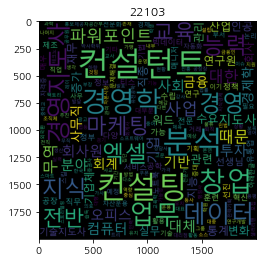

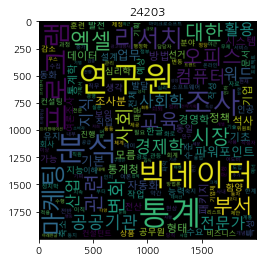

In [28]:
wordcloud(know_train[1].copy())

* 2019년도 Top5

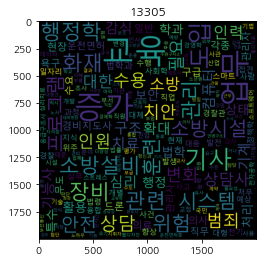

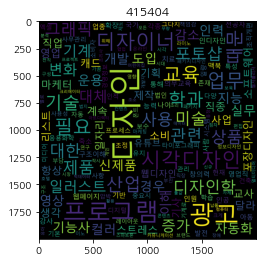

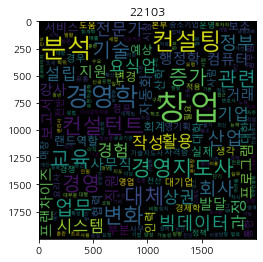

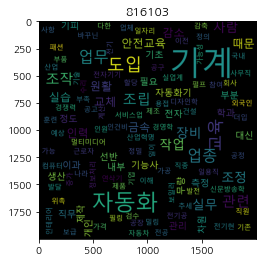

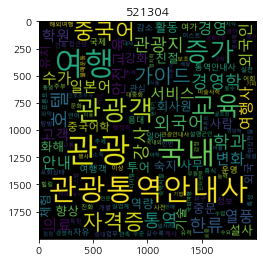

In [29]:
wordcloud(know_train[2].copy())

* 2020년도 Top5

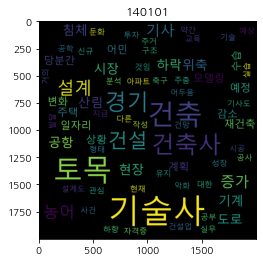

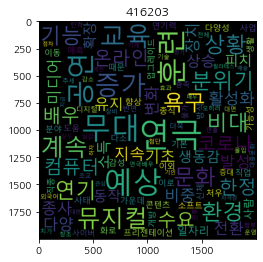

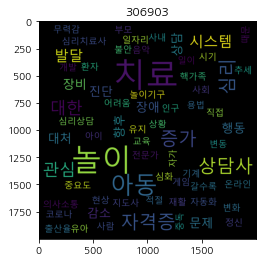

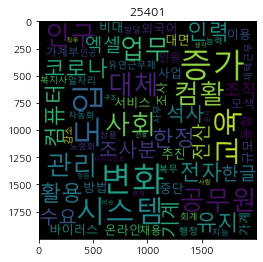

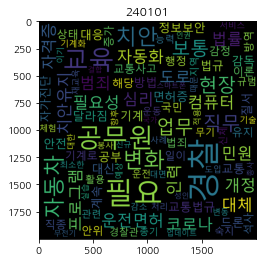

In [30]:
wordcloud(know_train[3].copy())

&nbsp;

* Label의 분포를 시각화 해보았을 때 unbalanced 함을 알 수 있습니다.

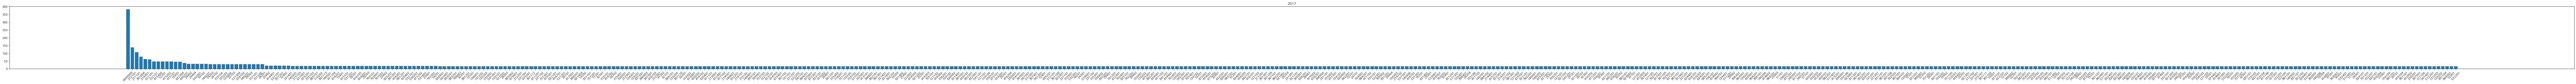

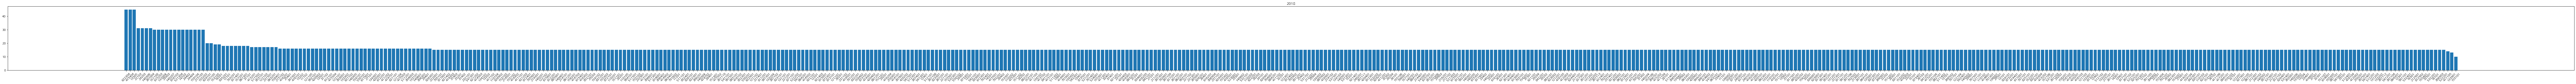

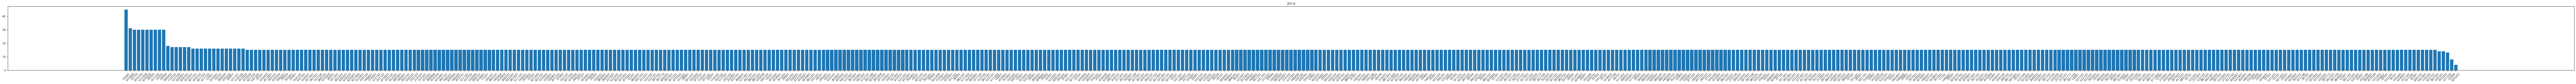

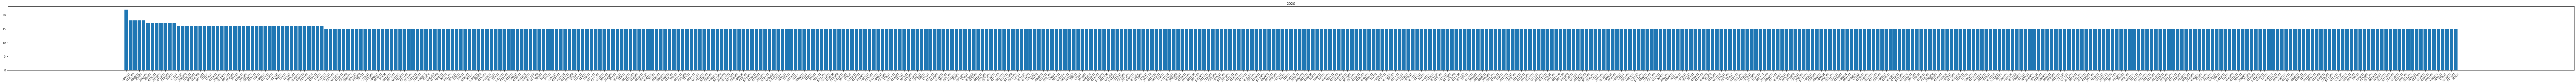

In [31]:
for idx, trainset in enumerate(know_train):
    key = trainset['knowcode'].value_counts().index.tolist()
    value = trainset['knowcode'].value_counts().tolist()
    x = np.arange(len(key))
    plt.figure(figsize=(120,4))
    plt.title(f"{years[idx]}")
    plt.bar(x, value)
    plt.xticks(x, key, rotation = 45)
    plt.tight_layout()
    plt.show()

&nbsp;

# 3. REMOVE OUTLIER DATA

* 각 범주형 변수가 일정범위값(ex 1~5)을 넘어가거나 그 이외 값인 경우 공백으로 변경합니다.

In [32]:
def outlier_change(x, limit_num):
    try:
        x = float(x)
        x = x if x < limit_num else ' '
    except:
        pass
    
    return x

outlier = {'2018' : ['bq20', 'bq35', 'bq38_2', 'bq39', 'bq40'],
           '2019' : ['bq8_1', 'bq12_2', 'bq12_3', 'bq12_4', 
            'bq14_1', 'bq14_2', 'bq14_3', 'bq25', 'bq29']}

for idx, year in enumerate(outlier):
    for col in outlier[year]:
        if col == 'bq40':
            limit_num = 100
        elif col == 'bq29':
            limit_num = 3
        else:
            limit_num = 10

        know_train[idx+1][col] = know_train[idx+1][col].apply(lambda x : outlier_change(x, limit_num))

* column의 변수값이 서로 바뀐것으로 추정되는 column들을 서로 교환합니다.

* 범주형, 숫자형 column에 문자열이 포함되어있을 경우 해당 값을 "total" column에 추가하여 하나의 문장으로 만듭니다.

In [33]:
def is_digit(str):
    try:
        tmp = float(str)
        return True
    except ValueError:
        return False

def outlier_processing(df, col1, col2):
    if col2 != 'total':    
        for idx, row in enumerate(df[col1]):
            if not is_digit(str(row)) and is_digit(str(df[col2][idx])):
                df[col1][idx] = df[col2][idx]
                df[col2][idx] = str(row)
    else:
        for idx, row in enumerate(df[col1]):
            if not is_digit(str(row)):
                df[col1][idx] = ' '
                df[col2][idx] = str(df[col2][idx]) + str(row)
                
text_outlier = {
            '2018' : ['bq37', 'bq35', 'bq40', 'bq4', 'bq5_1', 'bq28', 'bq34'],
            '2019' : ['bq27', 'bq6', 'bq7', 'bq8_3', 'bq9', 'bq10', 'bq11',
                'bq12_4', 'bq20','bq21_3', 'bq25']}

outlier_processing(know_train[1], 'bq37', 'bq37_1')
outlier_processing(know_train[1], 'bq4', 'bq4_1a')
outlier_processing(know_train[1], 'bq5_1', 'bq5_2')
outlier_processing(know_train[1], 'bq28', 'bq28_1')
outlier_processing(know_train[1], 'bq34', 'bq33')
outlier_processing(know_train[2], 'bq27', 'bq27_1')

for idx, out in enumerate(text_outlier):
    out = text_outlier[out]
    df = know_train[idx+1]
    for col in out:
        outlier_processing(df, col, 'total')

&nbsp;

# 4. FEATURE ENGINEERING

* 연령 변수를 (ex, 20대, 30대, 40대) 로 분할합니다.
* 연봉 변수를 (ex, 2000만원, 3000만원, 4000만원) 로 분할합니다.

In [34]:
def age_processing(x):
    try:
        x = int(x)
    except:
        x = 0
    
    if x >= 50:
        x = 5
    elif x >= 40:
        x = 4
    elif x >= 30:
        x = 3
    elif x >= 20:
        x = 2
    elif x >= 0:
        x = 1
        
    return x

def salary_processing(x):
    try:
        x = int(x)
    except:
        x = 0

    if x >= 10000:
        x = 7
    elif x >= 8000:
        x = 6
    elif x >= 6000:
        x = 5
    elif x >= 5000:
        x = 4
    elif x >= 4000:
        x = 3
    elif x >= 3000:
        x = 2
    elif x > 2000:
        x = 1
    else:
        x = 0
    return x

age_dic = {'2017': 'bq37', '2018': 'bq36', '2019': 'bq25', '2020': 'bq25'}
income1_dic = {'2017': 'bq41_1', '2018': 'bq41_1', '2019': 'bq31_1', '2020': 'bq30_1'}
income2_dic = {'2017': 'bq41_2', '2018': 'bq41_2', '2019': 'bq31_2', '2020': 'bq30_2'}
income3_dic = {'2017': 'bq41_3', '2018': 'bq41_3', '2019': 'bq31_3', '2020': 'bq30_3'}

for df, year in zip(know_train, years):
    age = age_dic[year]
    income_1 = income1_dic[year]  
    income_2 = income2_dic[year]  
    income_3 = income3_dic[year]
    
    df[age] = df[age].apply(lambda x : age_processing(x))
    df[income_1] = df[income_1].apply(lambda x : salary_processing(x))
    df[income_2] = df[income_2].apply(lambda x : salary_processing(x))
    df[income_3] = df[income_3].apply(lambda x : salary_processing(x))


* 직업별로 각각 unique하게 등장하는 명사가 있을것으로 추정할 수 있습니다.
* 문자열을 모아놓은 'total' column에 기호, 숫자, 영어를 제거합니다.
* konlpy 라이브러리의 Okt를 사용하여 'total' column의 명사만 추출합니다.
* countvectorizer 사용하여 각 명사 column 생성 합니다.

In [35]:
def text_cleaning(text):
    hangul = re.compile('[^가-힣?]')
    result = hangul.sub(' ',str(text))
    return result

def tw_tokenizer(text):
    drop_str = []
    
    if text:
        tokens_ko = okt.nouns(text)
        for idx, ko in enumerate(tokens_ko):
            if len(ko) == 1:
                drop_str.append(ko)
        for dr in drop_str:
            tokens_ko.remove(dr)
    else:
        tokens_ko = ['없음']
    
    return tokens_ko

year_token = {}
vec_col = {
        '2017' : ['total'],
        '2018' : ['total'],
        '2019' : ['total'],
        '2020' : ['total']}

okt = Okt()
    
for ind, year in tqdm(enumerate(years)):
    vec_year = vec_col[year]
    vec_list = []
    print(year)
    for col in vec_year:
        vector = CountVectorizer(tokenizer = tw_tokenizer)
        # vector = TfidfVectorizer(tokenizer = tw_tokenizer)
        know_train[ind][col] = know_train[ind][col].apply(lambda x : text_cleaning(x))
        
        wm = vector.fit_transform(know_train[ind][col].values.astype('U'))
        feat_names = list(vector.vocabulary_.keys())
        
        doc = [idx for idx, _ in enumerate (wm)]
        df = pd.DataFrame(data = wm.toarray (), index = doc, columns = vector.get_feature_names())
        know_train[ind] = pd.concat([know_train[ind], df], axis=1)
        vec_list.append(vector)
    year_token[year] = vec_list

0it [00:00, ?it/s]

2017


1it [00:39, 39.80s/it]

2018


2it [01:10, 34.59s/it]

2019


3it [01:29, 27.52s/it]

2020


4it [01:42, 25.58s/it]



* 공백인 변수는 0으로 변경합니다.

In [36]:
for idx, df in enumerate(know_train):
    column = train_col[idx]
    for col in column:
        df[col].replace(' ', '0', inplace=True)

* 숫자형 변수는 int형으로, 나머지 문자열 변수는 LabelEncoding 처리 합니다.

In [37]:
from sklearn.preprocessing import LabelEncoder

year_encoder = {}

for idx, (year, df) in enumerate(zip(years, know_train)):
    print(year)
    encoders = {}
    column = train_col[idx]
    for col in column:
        if col == 'ID':
            continue
        try:
            df[col] = df[col].map(int)
        except:
            encoder = LabelEncoder()
            df[col] = df[col].map(str)
            df[col] = encoder.fit_transform(df[col])
            encoders[col] = encoder
            
    year_encoder[year] = encoders

2017
2018
2019
2020


* 연도별 설문지마다 주제가 같은 type의 column들이 존재합니다. 
* 직업마다 각 설문 type에 맞는 선택값이 다를것으로 예상할 수 있습니다.
* 비슷한 문항끼리 값을 더하여 새로운 컬럼을 생성 합니다.

In [38]:
survey = {
        '2017' : [['bq12_1','bq14'],['bq15_1','bq15_3'], ['bq18_1','bq18_7'],
                 ['bq20','bq23'],['bq24_1','bq24_8'],['bq25','bq29']],
    
        '2018' : [['cq1', 'cq49'],['cq50_1','cq50_8'],['iq1','iq6'],['bq8_1','bq8_3'],
                  ['bq12_1','bq12_5']],
                  
        '2019' : [['sq1', 'sq16'],['bq8_1','bq8_3'],['bq12_1','bq12_5'],['bq13_1','bq13_3'],
                 ['bq14_1','bq14_5'],['bq15','bq17'],['bq18_1','bq18_4'],['bq18_5','bq19']],
                  
        '2020' : [['vq1','vq13'],['bq8_1','bq8_3'],['bq12_1','bq12_5'],
                 ['bq13_1', 'bq13_3'],['bq14_1','bq14_7'],['bq16_1','bq16_10'],['bq18_1','bq18_4'],
                 ['bq18_5','bq18_9'],['bq21_1','bq21_4'],['bq22_1','bq22_3'],['bq22_4','bq22_6'],
                 ['bq23_1','bq23_3']]    
}
years = ['2017', '2018', '2019', '2020']

for df, year in zip(know_train, years):
    survey_list = survey[year]
    sur_count = 0
    for sur in survey_list:
        sur_name = f'sur_{str(sur_count)}'
        df[sur_name] = df.loc[:, sur[0]:sur[1]].sum(axis=1).round(-1)
        sur_count+=1

* unique 길이가 전체 dataset의 rows 길이와 비슷하기 때문에 문자열 데이터 컬럼 제거합니다.

In [39]:
drop_col = {
            '2017' : ['bq5_2', 'bq19_1', 'bq31', 'total'],
            '2018' : ['bq5_2', 'bq28_1', 'bq30', 'total'],
            '2019' : ['bq5_2', 'bq20_1', 'bq18_10', 'total'],
            '2020' : ['bq5_2', 'bq20_1', 'bq18_10', 'total']
           }

for df, year in zip(know_train, years):
    cols = drop_col[year]
    df.drop(cols, axis=1, inplace=True)

* 연도별 dictionary에 전처리된 data 삽입합니다.

In [40]:
train_data = {}
for year, df in zip(years, know_train):
    train_data[year] = {'X': df.drop(['idx','knowcode'], axis=1), # ID제외
                        'y': df['knowcode']} 

In [41]:
import gc
del know_train
gc.collect()

74778

&nbsp;

# 5. READ TEST DATASETS

* Trainset과 동일한 방식으로 전처리 합니다.
* Testset 명사를 column으로 만들때 TrainSet CountVectorizer 연도별 학습된 모델을 불러온후 적용합니다.
* Testset의 string 데이터는 Trainset에서 학습한 LabelEncoder를 사용, 만약 Trainset에 없던 데이터이면 -1로 처리합니다.

In [42]:
know_test = [pd.read_csv(path) for path in sorted(glob(test_path))]

col_2017_test = know_test[0].columns
col_2018_test = know_test[1].columns
col_2019_test = know_test[2].columns
col_2020_test = know_test[3].columns

test_col = [col_2017_test, col_2018_test, col_2019_test, col_2020_test]
years = ['2017', '2018', '2019', '2020']

know_test[0]['total'] = know_test[0][['bq5_2', 'bq19_1', 'bq31', 'bq4_1a', 'bq4_1b', 'bq4_1c', 'bq30', 'bq32', 'bq33', 'bq34', 'bq38_1']].fillna('없음').sum(axis=1)
know_test[1]['total'] = know_test[1][['bq5_2', 'bq28_1', 'bq30', 'bq4_1a', 'bq4_1b', 'bq4_1c', 'bq29', 'bq31', 'bq32', 'bq33', 'bq37_1']].fillna('없음').sum(axis=1)
know_test[2]['total'] = know_test[2][['bq5_2', 'bq20_1', 'bq18_10', 'bq4_1a', 'bq4_1b', 'bq4_1c', 'bq22', 'bq23', 'bq24', 'bq27_1']].fillna('없음').sum(axis=1)
know_test[3]['total'] = know_test[3][['bq5_2', 'bq20_1', 'bq18_10', 'bq4_1a', 'bq4_1b', 'bq4_1c']].fillna('없음').sum(axis=1)

In [43]:
for idx, year in enumerate(outlier):
    for col in outlier[year]:
        if col == 'bq40':
            limit_num = 100
        elif col == 'bq29':
            limit_num = 3
        else:
            limit_num = 10

        know_test[idx+1][col] = know_test[idx+1][col].apply(lambda x : outlier_change(x, limit_num))

In [44]:
outlier_processing(know_test[1], 'bq37', 'bq37_1')
outlier_processing(know_test[1], 'bq4', 'bq4_1a')
outlier_processing(know_test[1], 'bq5_1', 'bq5_2')
outlier_processing(know_test[1], 'bq28', 'bq28_1')
outlier_processing(know_test[1], 'bq34', 'bq33')
outlier_processing(know_test[2], 'bq27', 'bq27_1')

for idx, out in enumerate(text_outlier):
    out = text_outlier[out]
    df = know_test[idx+1]
    for col in out:
        outlier_processing(df, col, 'total')

In [45]:
for df, year in zip(know_test, years):
    age = age_dic[year]
    income_1 = income1_dic[year]  
    income_2 = income2_dic[year]  
    income_3 = income3_dic[year]
    
    df[age] = df[age].apply(lambda x : age_processing(x))
    df[income_1] = df[income_1].apply(lambda x : salary_processing(x))
    df[income_2] = df[income_2].apply(lambda x : salary_processing(x))
    df[income_3] = df[income_3].apply(lambda x : salary_processing(x))

In [46]:
for ind, year in enumerate(years):
    vec_year = vec_col[year]
    vec_token = year_token[year]
    for col, token in zip(vec_year, vec_token):
        vector = token
        know_test[ind][col] = know_test[ind][col].apply(lambda x : text_cleaning(x))
        wm = vector.transform(know_test[ind][col].values.astype('U'))
        feat_names = list(vector.vocabulary_.keys())

        doc = [idx for idx, _ in enumerate (wm)]
        df = pd.DataFrame(data = wm.toarray (), index = doc, columns = vector.get_feature_names())
        know_test[ind] = pd.concat([know_test[ind], df], axis=1)

In [47]:
for idx, df in enumerate(know_test):
    column = test_col[idx]
    for col in column:
        df[col].replace(' ', '0', inplace=True)

In [48]:
for idx, (year, df) in enumerate(zip(years, know_test)):
    print(year)
    encoders = {}
    column = test_col[idx]
    for col in column:
        try:
            df[col] = df[col].map(int)
        except:
            encoder = year_encoder[year][col]
            df[col] = df[col].map(str)
            category_map = {category: idx for idx, category in enumerate(encoder.classes_)}
            df[col] = df[col].apply(lambda x: category_map[x] if x in category_map else -1) # train set에서 보지못한 카테고리변수 -1(UNK) 처리

2017
2018
2019
2020


In [49]:
for df, year in zip(know_test, years):
    survey_list = survey[year]
    sur_count = 0
    for sur in survey_list:
        print(sur)
        sur_name = f'sur_{str(sur_count)}'
        df[sur_name] = df.loc[:, sur[0]:sur[1]].sum(axis=1).round(-1)
        sur_count+=1

['bq12_1', 'bq14']
['bq15_1', 'bq15_3']
['bq18_1', 'bq18_7']
['bq20', 'bq23']
['bq24_1', 'bq24_8']
['bq25', 'bq29']
['cq1', 'cq49']
['cq50_1', 'cq50_8']
['iq1', 'iq6']
['bq8_1', 'bq8_3']
['bq12_1', 'bq12_5']
['sq1', 'sq16']
['bq8_1', 'bq8_3']
['bq12_1', 'bq12_5']
['bq13_1', 'bq13_3']
['bq14_1', 'bq14_5']
['bq15', 'bq17']
['bq18_1', 'bq18_4']
['bq18_5', 'bq19']
['vq1', 'vq13']
['bq8_1', 'bq8_3']
['bq12_1', 'bq12_5']
['bq13_1', 'bq13_3']
['bq14_1', 'bq14_7']
['bq16_1', 'bq16_10']
['bq18_1', 'bq18_4']
['bq18_5', 'bq18_9']
['bq21_1', 'bq21_4']
['bq22_1', 'bq22_3']
['bq22_4', 'bq22_6']
['bq23_1', 'bq23_3']


In [50]:
for df, year in zip(know_test, years):
    cols = drop_col[year]
    df.drop(cols, axis=1, inplace=True)

In [51]:
test_data = {}
for year, df in zip(years, know_test):
    test_data[year] =  {'X': df.iloc[:,1:]}

In [52]:
del know_test
gc.collect()

80

&nbsp;

# 6. MODEL TRAIN / INFERENCE

* 모델은 RandomForest를 사용합니다.
* n_estimators를 높일수록 성능이 높아지는것을 확인할 수 있습니다.
* Trainset의 target data가 대부분 unbalanced 하기 때문에 초기 weight를 균형있게 맞추어 훈련 합니다.

In [53]:
rf_predicts = [] 
for year in tqdm(years):
    model = RandomForestClassifier(n_estimators=1536, random_state=123456, n_jobs=-1, class_weight="balanced")
    model.fit(train_data[year]['X'].iloc[:, :], train_data[year]['y'])
    pred = model.predict(test_data[year]['X'])
    rf_predicts.extend(pred)
    
    del train_data[year]
    del model
    del test_data[year]
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.75s/it]


&nbsp;

# 7. SUBMISSION

In [54]:
submission = pd.read_csv(submission_path)

In [55]:
submission['knowcode'] = rf_predicts

submission.to_csv(save_path, index=False)